In [1]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx

### fastRG graph sampling (https://arxiv.org/pdf/1703.02998.pdf)
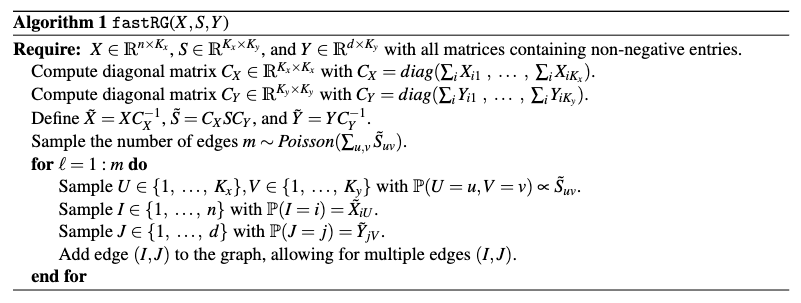

In [32]:
class SBM(dist.TorchDistribution):
    def __init__(self, X, S, Y=None):
        
        # source node membership matrices
        self.X = X
        self.n_batches, self.n_nodes, self.n_blocks = X.shape

        super().__init__(
            batch_shape = torch.Size([self.n_batches]),
            event_shape = torch.Size([self.n_nodes, self.n_nodes])
        )
        
        # block connection probabilities
        self.S = S
        assert S.shape == self.batch_shape + torch.Size([self.n_blocks, self.n_blocks])
        
        # sink node membership matrix (same as X by default)
        if Y is not None:
            self.Y = Y
        else:
            self.Y = X
            
        # log expectation matrices
        self.log_expectation = torch.matmul(X, torch.matmul(S, X.transpose(-1,-2))).log()
            
        # membership count matrices
        CX = torch.stack(
            tuple(map(torch.diag, self.X.sum(1)))
        )
        CY = torch.stack(
            tuple(map(torch.diag, self.Y.sum(1)))
        )
        
        # membership probabilitites
        self.Xtilde = torch.matmul(self.X, torch.inverse(CX))
        self.Ytilde = torch.matmul(self.Y, torch.inverse(CY))
                
        # block degree matrix
        self.Stilde = torch.matmul(CX, torch.matmul(S, CY))
        
        # distributions
        self.num_edge_dist = dist.Poisson(self.Stilde.sum([1,2]))
        self.block_dist = dist.Multinomial(probs=self.Stilde.flatten(1))
        
        
    def sample(self, sample_shape=torch.Size()):
        
        sample_shape = torch.Size(sample_shape)
        assert len(sample_shape) in [0, 1], "only 0D or 1D sampling supported"

        # number of edges per sample
        num_edges = self.num_edge_dist.sample(sample_shape).int()
        
        if len(sample_shape) == 0:
            num_edges = num_edges.unsqueeze(0)
        
        tot_edges_per_batch = num_edges.sum(0)
        max_edges_per_batch = tot_edges_per_batch.max()
        
        # sample block selections for each edge
        blocks = self.block_dist.sample(max_edges_per_batch.unsqueeze(0))
        
        # create block selection matrices
        blocks = blocks.reshape(
            torch.Size([max_edges_per_batch]) +
            self.batch_shape +
            torch.Size([self.n_blocks]*2)
        )
        
        # select node probabilities for each edge
        source_probs = torch.matmul(self.Xtilde, blocks).sum(-1)
        sink_probs = torch.matmul(blocks, self.Ytilde.transpose(-1, -2)).sum(-2)
                
        # sample node selections for each edge
        sources = dist.Categorical(source_probs).sample()
        sinks = dist.Categorical(sink_probs).sample()
        
        # construct edge lists for each sample and batch
        coords = []
        for batch_coo in range(self.batch_shape.numel()):
            
            tot_edges = tot_edges_per_batch[batch_coo]
            n_edges = num_edges[:, batch_coo]
            
            # slice out edges for this batch
            edges = torch.stack([
                sources[:tot_edges, batch_coo],
                sinks[:tot_edges, batch_coo]
            ])
            
            # split edges into samples
            edge_lists = torch.split(edges, tuple(n_edges), -1)
            
            # construct 4-D (sample, batch, source, sink) coordinates
            for sample_coo, edge_list in enumerate(edge_lists):
                n = edge_list.shape[-1]
                coords.append(
                    torch.concat([
                        torch.Tensor([sample_coo]).int().expand([1, n]),
                        torch.Tensor([batch_coo]).int().expand([1, n]),
                        edge_list
                    ])
                )
                
        coords = torch.concat(coords, -1)
        
        # remove sample coordinate if not in use
        if len(sample_shape) == 0:
            coords = coords[1:, :]
        
        # construct (n_samples * n_batches) sparse (n_nodes * n_nodes) adjacency matrices
        return torch.sparse_coo_tensor(
            indices = coords,
            values = torch.ones(coords.shape[-1]),
            size = self.shape(sample_shape)
        )

    def log_prob(self, x):
        # work in progress. general idea is to sum entries in log expectation matrix?
        pass

        
        

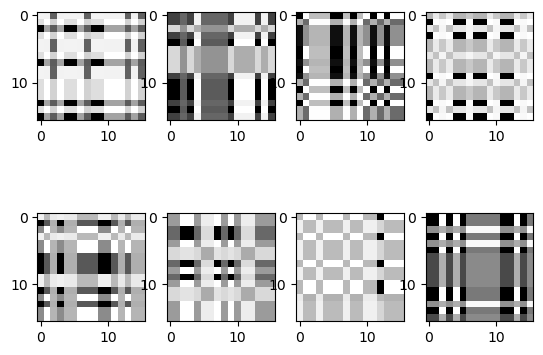

In [69]:
# random parameters
n_batches = 8
n_nodes = 16
n_blocks = 3

X = dist.OneHotCategorical(torch.Tensor([1/n_blocks]).expand([n_blocks])).sample([n_batches, n_nodes])
S = torch.rand([n_batches, n_blocks, n_blocks])
sbm = SBM(X,S)

# expectations
fig, axarr = plt.subplots(2, n_batches//2)
for b, ax in enumerate(axarr.flat):
    ax.imshow(sbm.log_expectation[b], cmap=plt.cm.gray)

In [78]:
ei = sbm.sample([500])

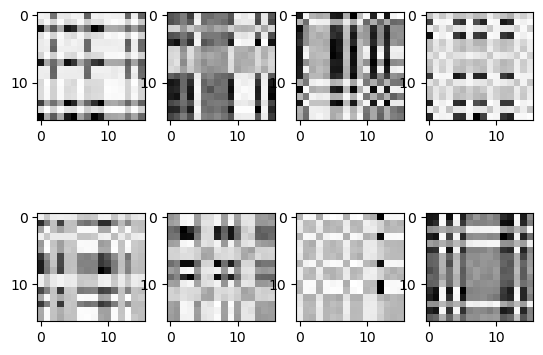

In [79]:
log_sample_mean = ei.to_dense().mean(0).log()
fig, axarr = plt.subplots(2, n_batches//2)
for b, ax in enumerate(axarr.flat):
    ax.imshow(log_sample_mean[b], cmap=plt.cm.gray)